In [1]:
import cv2
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
from shapely.geometry import LineString, Point, MultiLineString

def threshold_by_contour_count(contour_count):
    if contour_count <= 50:
        return 500
    elif contour_count <= 100:
        return 1000
    elif contour_count <= 500:
        return 5000
    elif contour_count <= 1500:
        return 7500
    else:
        return 10000

def detect_plant_rows_with_circles(image_path, threshold_default = None):
    # load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # change color from rgb to hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # define green range (may need to be adjusted)
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # morphological filter (noise removal)
    kernel = np.ones((5,5), np.uint8)
    mask_clean = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

    # find contours
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Anzahl gefundener Konturen: {len(contours)}")

    if threshold_default is None:
        # dynamic threshold
        threshold = threshold_by_contour_count(len(contours))
    else:
        threshold = threshold_default

    # copy image to show recognized plants with circles
    img_rects = img_rgb.copy()

    # array of centers of circles
    circles = []

    for cnt in contours:
        area = cv2.contourArea(cnt)

        if area > threshold:  
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            center = (int(x), int(y))
            radius = int(radius)
            circles.append((center, radius))
#             print(f"Kreis Werte: Mittelpunkt: {center}, Radius: {radius}")
            cv2.circle(img_rects, center, radius, (0, 0, 255), 5)

    # show partial results
    
    print(f"Pflanzenkonturen mit Threshold: {threshold}")
    
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Grün Maske")
    plt.imshow(mask_clean, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Erkannte Pflanzen")
    plt.imshow(cv2.cvtColor(img_rects, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

    return circles

Anzahl gefundener Konturen: 1125
Pflanzenkonturen mit Threshold: 7500


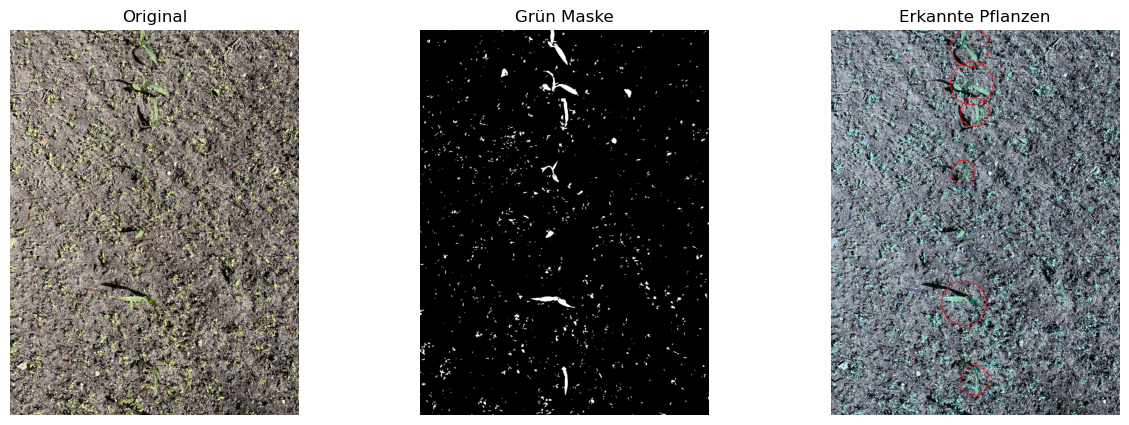

circles: [((1509, 3673), 148), ((1393, 2861), 234), ((1384, 1487), 124), ((1503, 862), 151), ((1474, 558), 225), ((1456, 182), 203)]

 Zeichne 6 crop circles
Anzahl gefundener Konturen: 1125
Pflanzenkonturen mit Threshold: 100


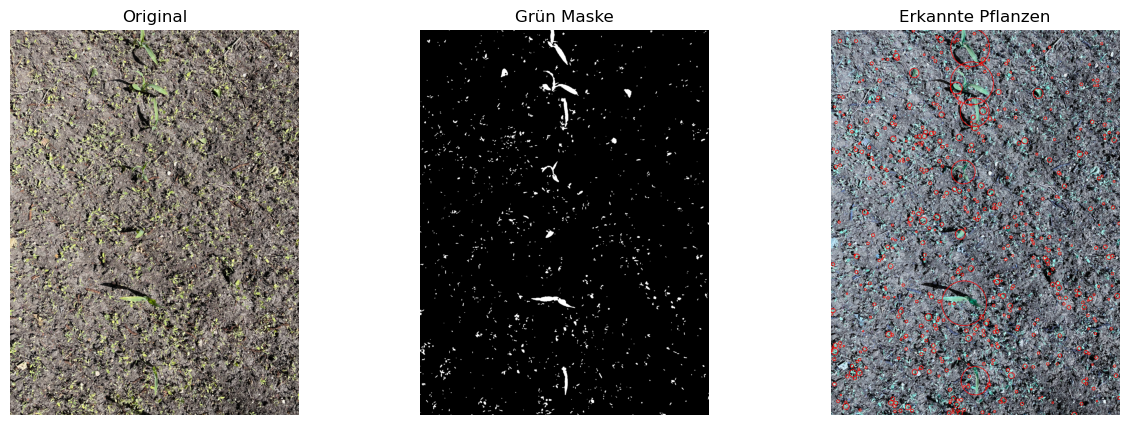


 Zeichne 534 crop circles
28 intersecting circles (-> crops) found.


Centers of intersecting circles (-> crops): 
 [((1509, 3673), 148), ((1393, 2861), 234), ((1384, 1487), 124), ((1503, 862), 151), ((1474, 558), 225), ((1456, 182), 203), ((1509, 3673), 148), ((1393, 2861), 234), ((1374, 2562), 14), ((1466, 2498), 29), ((1353, 2140), 52), ((1402, 2079), 9), ((1430, 1907), 10), ((1406, 1879), 11), ((1398, 1850), 9), ((1401, 1756), 11), ((1441, 1677), 11), ((1384, 1487), 124), ((1453, 1265), 16), ((1471, 1206), 22), ((1505, 1018), 37), ((1488, 913), 22), ((1462, 784), 11), ((1451, 731), 8), ((1503, 862), 151), ((1474, 558), 225), ((1428, 389), 19), ((1456, 182), 203)] 


506 non-intersecting circles (-> weeds) found.


Centers of non-intersecting circles (-> weeds):
 [((2545, 4027), 25), ((1653, 4024), 9), ((1237, 4010), 21), ((1278, 4006), 10), ((1350, 4012), 26), ((1585, 4004), 15), ((1711, 3995), 10), ((669, 3993), 13), ((727, 3988), 16), ((1329, 3990), 15), ((847, 3986), 16), ((139

In [ ]:
# find all circles crossing the lines -> these areas need to be blocked as they contain crops
# any remaining plants are weeds

img_path = '2_dataset/images/corn/IMG_4043.png'

# parameter for Hough-Transformation
minLineLength = 100
thresholdHoughLines = 5
maxLineGap = 2500

# parameter for filtering
minAngle = 85
maxAngle = 95
lineArea = 300

# find green contours and the center of their surrounding circle
# at this point primarily large plants (crops) are added to the circles array
circles = detect_plant_rows_with_circles(img_path)
print(f"circles: {circles}")


imgOutput = cv2.imread(img_path)
height, width = imgOutput.shape[:2]
x_center = width // 2

# create empty image
imgHoughTransformation = np.zeros((height, width), dtype=np.uint8)

# add center of circles 
print(f"\n Zeichne {len(circles)} crop circles")
for circle in circles:
    cv2.circle(imgHoughTransformation, circle[0], radius=10, color=255, thickness=5)
    cv2.circle(imgOutput, circle[0], radius=circle[1], color=(0, 0, 255), thickness=5)
    
# use Hough-Line-Transformation
lines = cv2.HoughLinesP(imgHoughTransformation, rho=1, theta=np.pi/180, threshold=thresholdHoughLines, minLineLength=minLineLength, maxLineGap=maxLineGap)
    
#add weeds by adding a low threshold value no matter the crop contours
circles += detect_plant_rows_with_circles(img_path, 100)

# add center of circles 
print(f"\n Zeichne {len(circles)} crop circles")
for circle in circles:
    cv2.circle(imgHoughTransformation, circle[0], radius=10, color=255, thickness=5)
    cv2.circle(imgOutput, circle[0], radius=circle[1], color=(0, 0, 255), thickness=5)

# calculate boundary of circles
# buffer creates a circular polygon approximation around the center point using given radius
circlesWithBoundary = [(Point(center), Point(center).buffer(radius).boundary) for center, radius in circles]

# visualize the lines of the crops
if lines is not None:
    out = np.empty((len(lines), len(circles)), dtype=bool)

    for j, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        dx = x2 - x1
        dy = y2 - y1
        theta = np.arctan2(dy, dx)  # angle of lines in radians

        angle_deg = abs(np.degrees(theta))  # only positive angles

        # norm angles to [0°, 180°]
        if angle_deg > 180:
            angle_deg -= 180

        # only approx. vertical lines
        if minAngle <= angle_deg <= maxAngle:
            x_mean = (x1 + x2) / 2

            # only lines in the center of the image are relevant
            if abs(x_mean - x_center) <= lineArea:
                cv2.line(imgOutput, (x1, y1), (x2, y2), (0, 0, 255), 10)

                # convert to LineString for calculating intersections
                lsLine = LineString([(x1, y1), (x2, y2)])

                for i, (center, boundary) in enumerate(circlesWithBoundary):
                    out[j, i] = lsLine.intersects(boundary)

    # get coordinates of intersecting and non-intersecting circles
    circleIntersections = out.any(axis=0)

    withIntersections = [circles[i] for i in np.where(circleIntersections)[0]]
    noIntersections = [circles[i] for i in np.where(~circleIntersections)[0]]
    print(f"{len(withIntersections)} intersecting circles (-> crops) found.\n\n")
    print("Centers of intersecting circles (-> crops): \n", withIntersections, "\n\n")
    print(f"{len(noIntersections)} non-intersecting circles (-> weeds) found.\n\n")
    print("Centers of non-intersecting circles (-> weeds):\n", noIntersections, "\n\n")
    
    # add circles 
    print(f"\n Zeichne {len(noIntersections)} weed circles")
    for weed in noIntersections:
        cv2.circle(imgOutput, weed[0], radius=weed[1], color=(255, 0, 0), thickness=5)
    print(f"\n Zeichne {len(withIntersections)} crop circles")
    for crop in withIntersections:
        cv2.circle(imgOutput, crop[0], radius=crop[1], color=(0, 0, 255), thickness=5)

    # downscale image
    imgOutput = cv2.resize(imgOutput, None, fx = 0.15, fy = 0.15)
    cv2.imshow('Linien', imgOutput)
    cv2.waitKey(0)







 